# Tweet Emotion Recognition: Natural Language Processing with TensorFlow



### Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)




In [1]:
#installing Hugging Face's nlp package
%pip install nlp

Note: you may need to restart the kernel to use updated packages.


In [2]:
#importing necessary libraries

%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.6.0


In [3]:
#Importing Tweet Emotion Dataset
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


In [4]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
#Creating train, validation ,test sets
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [6]:
#Extracting Tweets and Labels from samples
def get_tweet(data):
  tweets = [x['text'] for x  in data]
  labels = [y['label'] for y in data]
  return tweets, labels

In [7]:
tweets, labels = get_tweet(train)

In [8]:
tweets[0],labels[0]

('i didnt feel humiliated', 'sadness')

In [9]:
#Tokenizing the Tweets
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 10000, oov_token = '<UNK>')
tokenizer.fit_on_texts(tweets)

tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [10]:
tweets[0]

'i didnt feel humiliated'

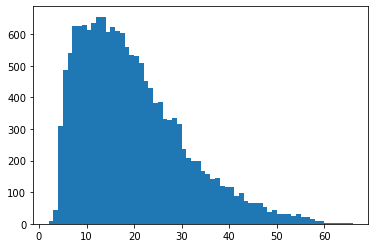

In [11]:
#Plotting Hist of frequency of tweets which contains same no of words vs No of words in the tweets
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [12]:
#Padding and truncating sequences
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_sequences(tokenizer,tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences,truncating = 'post',padding = 'post',maxlen = maxlen)
  return padded

In [13]:
padded_train_sequences = get_sequences(tokenizer,tweets)

In [14]:
padded_train_sequences[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [15]:
classes = set(labels)
classes

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

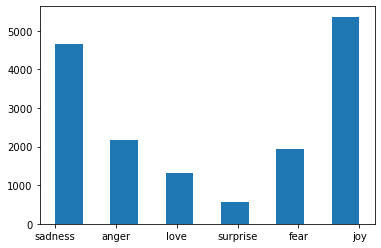

In [16]:
plt.hist(labels,bins = 11)
plt.show()

In [17]:
#Creating multimap for easy accessing
class_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v,k) for k,v in class_to_index.items())

In [18]:
class_to_index

{'fear': 0, 'sadness': 1, 'surprise': 2, 'joy': 3, 'anger': 4, 'love': 5}

In [19]:
index_to_class

{0: 'fear', 1: 'sadness', 2: 'surprise', 3: 'joy', 4: 'anger', 5: 'love'}

In [20]:
#Label encoding
names_to_ids = lambda labels:np.array([class_to_index.get(x) for x in labels])

In [21]:
train_labels = names_to_ids(labels)
print(train_labels[0])

1


In [22]:
#The Model
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000,16,input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6,activation='softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer= 'adam',
    metrics = ['accuracy']
)
model.summary()

In [ ]:
#Validation set
val_tweets,val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer,val_tweets)
val_labels = names_to_ids(val_labels)

In [ ]:
val_tweets[0] , val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 3)

In [ ]:
#Training the model
h = model.fit(
    padded_train_sequences,train_labels,
    validation_data=(val_seq,val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 15s 16ms/step - loss: 1.3517 - accuracy: 0.4809 - val_loss: 0.9184 - val_accuracy: 0.6755
Epoch 2/20
500/500 [==============================] - 6s 13ms/step - loss: 0.6425 - accuracy: 0.7768 - val_loss: 0.6057 - val_accuracy: 0.7900
Epoch 3/20
500/500 [==============================] - 7s 13ms/step - loss: 0.3886 - accuracy: 0.8679 - val_loss: 0.5065 - val_accuracy: 0.8340
Epoch 4/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2436 - accuracy: 0.9202 - val_loss: 0.4254 - val_accuracy: 0.8805
Epoch 5/20
500/500 [==============================] - 7s 13ms/step - loss: 0.1489 - accuracy: 0.9553 - val_loss: 0.4161 - val_accuracy: 0.8790
Epoch 6/20
500/500 [==============================] - 7s 13ms/step - loss: 0.1123 - accuracy: 0.9668 - val_loss: 0.4159 - val_accuracy: 0.8795


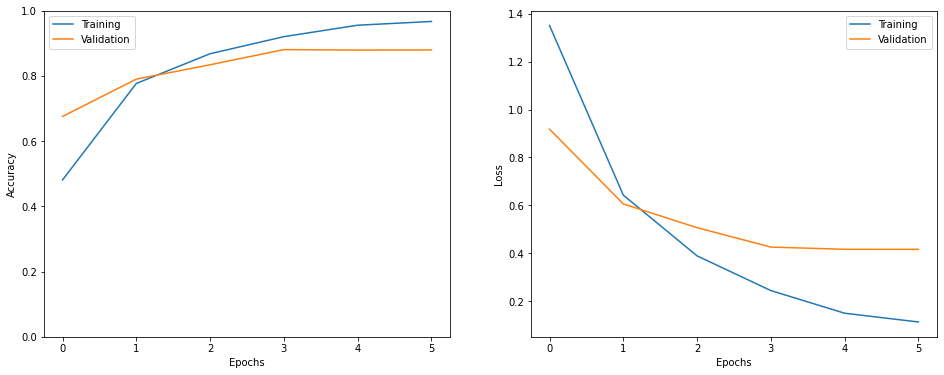

In [ ]:
#Evaluating the Model
show_history(h)

In [ ]:
#Test set creation
test_tweets,test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer,test_tweets)
test_labels = names_to_ids(test_labels)

In [ ]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.4480 - accuracy: 0.8690


In [ ]:
#Prediction component
i = random.randint(0,len(test_labels)-1)
 print("Sentence: ",test_tweets[i])
 print("Emotion: ",index_to_class[test_labels[i]])

 p = model.predict(np.expand_dims(test_seq[i],axis=0))[0]
 pred_class = index_to_class[np.argmax(p).astype('uint8')]

 print('Predicted Emotion: ',pred_class)

Sentence:  im not sure but theres nothing that will get a person feeling amorous faster than a stay in a hotel
Emotion:  love
Predicted Emotion:  love


In [ ]:
#Creating Confusion Matrix
preds = model.predict(test_seq)

#above is model.predict_classes(test_seq) but tensorflow shows up some error.

show_confusion_matrix(test_labels,preds,list(classes))